导入相关库

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV,KFold, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from xgboost import XGBRegressor

from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

数据预处理

In [2]:
# 读取数据
df = pd.read_csv("data/processed_binary_compounds.csv")

# 要处理的列
stress_cols = ["sxy", "syz", "szx"]

# 替换值为0的项为该列的非零中位数
for col in stress_cols:
    non_zero_median = df.loc[df[col] != 0, col].median()
    df[col] = df[col].replace(0, non_zero_median)

print(df.shape)
df.columns.values

(10000, 22)


array(['delta_e', 'stability', 'natoms', 'ntypes',
       'element_1_atomic_radii', 'element_1_electronegativity',
       'element_1_mass', 'element_1_covalent_radii',
       'element_1_first_ionization_energy', 'element_2_atomic_radii',
       'element_2_electronegativity', 'element_2_mass',
       'element_2_covalent_radii', 'element_2_first_ionization_energy',
       'spacegroup_id', 'volume_pa', 'sxx', 'syy', 'szz', 'sxy', 'syz',
       'szx'], dtype=object)

特征工程

In [3]:
# 元素属性差异/组合类（11个）
df['electronegativity_diff'] = df['element_1_electronegativity'] - df['element_2_electronegativity']
df['electronegativity_ratio'] = df['element_1_electronegativity'] / (df['element_2_electronegativity'] + 1e-6)

df['atomic_radii_diff'] = df['element_1_atomic_radii'] - df['element_2_atomic_radii']
df['atomic_radii_ratio'] = df['element_1_atomic_radii'] / (df['element_2_atomic_radii'] + 1e-6)

df['covalent_radii_diff'] = df['element_1_covalent_radii'] - df['element_2_covalent_radii']
df['covalent_radii_sum'] = df['element_1_covalent_radii'] + df['element_2_covalent_radii']

df['mass_diff'] = df['element_1_mass'] - df['element_2_mass']
df['mass_ratio'] = df['element_1_mass'] / (df['element_2_mass'] + 1e-6)
df['mass_product'] = df['element_1_mass'] * df['element_2_mass']

df['ionization_energy_diff'] = df['element_1_first_ionization_energy'] - df['element_2_first_ionization_energy']
df['avg_ionization_energy'] = (df['element_1_first_ionization_energy'] + df['element_2_first_ionization_energy']) / 2

# 结构/体积密度类（6个）
df['atom_density'] = df['natoms'] / (df['volume_pa'] + 1e-6)
df['volume_pa_per_type'] = df['volume_pa'] / (df['ntypes'] + 1e-6)

df['avg_atomic_radii'] = (df['element_1_atomic_radii'] + df['element_2_atomic_radii']) / 2
df['avg_mass'] = (df['element_1_mass'] + df['element_2_mass']) / 2
df['avg_electronegativity'] = (df['element_1_electronegativity'] + df['element_2_electronegativity']) / 2
df['avg_covalent_radii'] = (df['element_1_covalent_radii'] + df['element_2_covalent_radii']) / 2

# 应力统计类（6个）
stress_cols = ['sxx', 'syy', 'szz', 'sxy', 'syz', 'szx']

df['stress_mean'] = df[['sxx', 'syy', 'szz']].mean(axis=1)
df['stress_std'] = df[['sxx', 'syy', 'szz']].std(axis=1)
df['shear_stress_mean'] = df[['sxy', 'syz', 'szx']].mean(axis=1)
df['shear_stress_std'] = df[['sxy', 'syz', 'szx']].std(axis=1)

df['stress_max'] = df[stress_cols].max(axis=1)
df['stress_min'] = df[stress_cols].min(axis=1)
df['stress_norm'] = np.sqrt((df[stress_cols] ** 2).sum(axis=1))

# 高阶组合类（3个）
df['electronegativity_diff_squared'] = df['electronegativity_diff'] ** 2
df['mass_diff_squared'] = df['mass_diff'] ** 2
df['radii_product'] = df['element_1_atomic_radii'] * df['element_2_atomic_radii']

print(df.shape)
df.columns.values

(10000, 49)


array(['delta_e', 'stability', 'natoms', 'ntypes',
       'element_1_atomic_radii', 'element_1_electronegativity',
       'element_1_mass', 'element_1_covalent_radii',
       'element_1_first_ionization_energy', 'element_2_atomic_radii',
       'element_2_electronegativity', 'element_2_mass',
       'element_2_covalent_radii', 'element_2_first_ionization_energy',
       'spacegroup_id', 'volume_pa', 'sxx', 'syy', 'szz', 'sxy', 'syz',
       'szx', 'electronegativity_diff', 'electronegativity_ratio',
       'atomic_radii_diff', 'atomic_radii_ratio', 'covalent_radii_diff',
       'covalent_radii_sum', 'mass_diff', 'mass_ratio', 'mass_product',
       'ionization_energy_diff', 'avg_ionization_energy', 'atom_density',
       'volume_pa_per_type', 'avg_atomic_radii', 'avg_mass',
       'avg_electronegativity', 'avg_covalent_radii', 'stress_mean',
       'stress_std', 'shear_stress_mean', 'shear_stress_std',
       'stress_max', 'stress_min', 'stress_norm',
       'electronegativity_diff_squ

特征选择

In [4]:
# 目标列
target_col = 'delta_e'

# 特征列（排除 sample_id 和目标列）
feature_cols = [col for col in df.columns if col not in ['delta_e','sxy','syz','szx']]

# 特征与标签
X = df[feature_cols]
y = df[target_col]

划分训练集和测试集

In [5]:
# 训练/测试划分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 输出维度信息确认
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8000, 45)
X_test shape: (2000, 45)
y_train shape: (8000,)
y_test shape: (2000,)


模型准备

In [6]:

def train_xgb_quantile(X_train, y_train, quantile, param_grid):
    model = XGBRegressor(objective='reg:quantileerror', quantile_alpha=quantile)
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='neg_mean_absolute_error',
        cv=kfold,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)
    return grid.best_estimator_, grid.best_params_


# 设置搜索参数空间 
param_grid = {
    "n_estimators": [400, 450],
    "max_depth": [7, 8],
    "learning_rate": [0.04, 0.05, 0.06],
    "subsample": [0.8],
    "colsample_bytree": [0.75, 0.8, 0.85],
    "reg_alpha": [0.5],
    "reg_lambda": [1.0]
}

模型训练

In [7]:

quantiles = [0.05, 0.5, 0.95]
model_dict = {}
best_params_dict = {}

# 分位数回归模型训练
for q in quantiles:
    best_model, best_params = train_xgb_quantile(X_train, y_train, q, param_grid)
    model_dict[q] = best_model
    best_params_dict[q] = best_params
    print(f"Best params for quantile {q}: {best_params}")

Best params for quantile 0.05: {'colsample_bytree': 0.75, 'learning_rate': 0.06, 'max_depth': 8, 'n_estimators': 450, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
Best params for quantile 0.5: {'colsample_bytree': 0.85, 'learning_rate': 0.06, 'max_depth': 8, 'n_estimators': 450, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}
Best params for quantile 0.95: {'colsample_bytree': 0.8, 'learning_rate': 0.06, 'max_depth': 8, 'n_estimators': 450, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.8}


模型性能评估

In [8]:
# 模型预测
y_pred = model_dict[0.5].predict(X_test)

# 计算指标
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# 输出结果
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

MAE:  0.1025
RMSE: 0.1837
R²:   0.9459


不确定性评估

In [9]:
# 设置置信度
confidence = 0.90
z_score = norm.ppf(0.5 + confidence / 2)

# 获取预测区间
down = model_dict[0.05].predict(X_test)
up = model_dict[0.95].predict(X_test)

# 估算标准差
std_pred = np.abs((up - down) / (2 * z_score))

# 区间上下限
lower = y_pred - z_score * std_pred
upper = y_pred + z_score * std_pred

# PICP：真实值是否落在置信区间
picp = np.mean((y_test >= lower) & (y_test <= upper))

# MPIW：置信区间平均宽度
mpiw = np.mean(upper - lower)

# Sharpness：置信区间的集中度
sharpness = np.mean(std_pred)

# 输出不确定性指标
print(f"PICP (90%): {picp:.4f}")
print(f"MPIW (90%): {mpiw:.4f}")
print(f"Sharpness:  {sharpness:.4f}")

PICP (90%): 0.9010
MPIW (90%): 0.4983
Sharpness:  0.1515


可视化

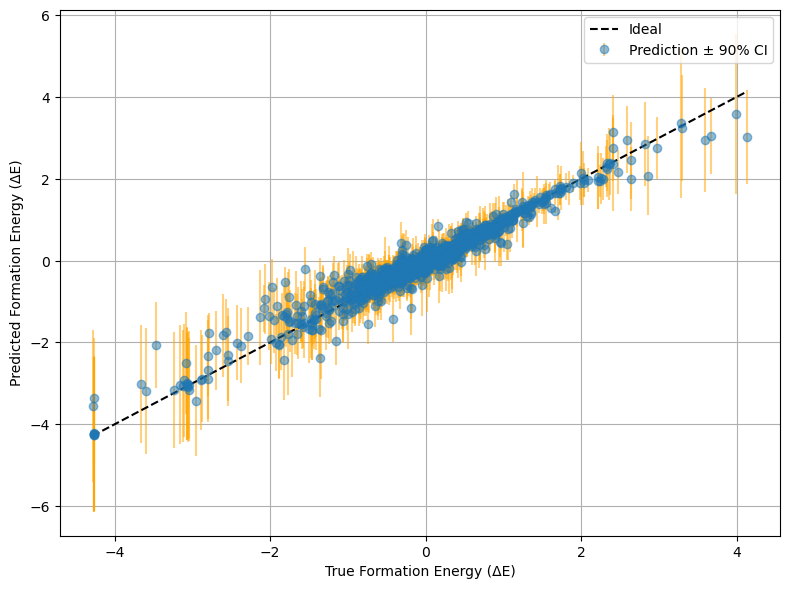

In [10]:
# 可视化：真实值vs预测值+区间
plt.figure(figsize=(8, 6))
plt.errorbar(y_test, y_pred, yerr=z_score * std_pred, fmt='o', ecolor='orange', alpha=0.5, label='Prediction ± 90% CI')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='Ideal')
# plt.title("90% Confidence Interval of Predictions vs Ground Truth")
plt.xlabel("True Formation Energy (ΔE)")
plt.ylabel("Predicted Formation Energy (ΔE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

模型结果保存

In [11]:
# 模型预测
y_pred = model_dict[0.5].predict(X_test)

df_xgb = pd.DataFrame({
    'true': y_test,
    'pred': y_pred,
    'std': std_pred
})

df_xgb['residual'] = df_xgb['true'] - df_xgb['pred']

df_xgb.to_csv('data/xgb_results.csv', index=False)